## How to handle outdoor challenge dataset?

In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import pylab as plt
import ujson as json
from numpy.linalg import inv

# set the dataset root directory
#DATA_ROOT = '/data2/data/challenge'
DATA_ROOT = '/home/sangjin/NAS/sangjin/Naverlabs_challenge/outdoor'

calib = json.load(open(os.path.join(DATA_ROOT, 'calibration.json'), 'r'))

images_path = os.path.join(DATA_ROOT, 'pangyo', 'train', 'images')
cam_poses = np.loadtxt(os.path.join(images_path, 'poses.txt')).reshape(-1, 4, 4)
cam_timestamps = np.loadtxt(os.path.join(images_path,'timestamps.txt'))
print('We have %d left images w/ poses'%(len(cam_poses)))
print('We have %d left images w/ poses'%(len(cam_poses)))


images_path = os.path.join(DATA_ROOT, 'pangyo', 'train', 'images')
cam_poses = np.loadtxt(os.path.join(images_path, 'poses.txt')).reshape(-1, 4, 4)
lcam_timestamps = np.loadtxt(os.path.join(images_path,'timestamps.txt'))
print('We have %d left images w/ poses'%(len(cam_poses)))

lidar_path = os.path.join(DATA_ROOT, 'pangyo', 'train', 'lidars')
lidar_poses = np.loadtxt(os.path.join(lidar_path, 'poses.txt')).reshape(-1, 4, 4)
lidar_timestamps = np.loadtxt(os.path.join(lidar_path, 'timestamps.txt'))
print('We have %d lidar w/ poses'%(len(lidar_poses)))

LCam_RT = np.array(calib['Extrinsic']['LCam'])
RCam_RT = np.array(calib['Extrinsic']['RCam'])
LCam_K = np.array(calib['Intrinsic']['LCam']['K'])
RCam_K = np.array(calib['Intrinsic']['RCam']['K'])
LiDAR_RT = np.array(calib['Extrinsic']['Lidar'])

def get_Limage(idx, sensor='left'):
    return cv2.imread(os.path.join(images_path, sensor, '%06d.png'%idx))[:,:,::-1]

def get_Rimage(idx, sensor='right'):
    return cv2.imread(os.path.join(images_path, sensor, '%06d.png'%idx))[:,:,::-1]

def get_lidar(idx):
    pnts = np.load(os.path.join(lidar_path, '%05d.npy'%idx))
    invalid = np.logical_and(np.logical_and(pnts[:,0] == 0, pnts[:,1] == 0), pnts[:,2] == 0)
    return pnts[~invalid]

def slow_and_naive_hidden_point_removal(in_uv, in_cam_pnts):
    depth = in_cam_pnts[:,2]
    depth_order = np.argsort(depth)
    uv_int = uv.astype(int)[:,:2]
    nearest_idx = dict()
    for pnt_idx in depth_order:
        pnt_uv = tuple(uv_int[pnt_idx])
        if nearest_idx.get(pnt_uv) is None:
            nearest_idx[pnt_uv] = pnt_idx
    nearest_idx = np.array(list(nearest_idx.values()))
    cam_pnts_visible = in_cam_pnts[nearest_idx]
    uv_visible = in_uv[nearest_idx]
    return uv_visible, cam_pnts_visible

We have 48117 left images w/ poses
We have 48098 lidar w/ poses


## How to stack multiple LiDAR frames?

In [2]:
img_idx = 30000
img = get_Limage(img_idx)
img_ts = lcam_timestamps[img_idx]
veh_pose = lcam_poses[img_idx]

merged_pnts = []
# LiDAR indices captured within {stack_range} secs from image timestamp
stack_ts_range = 3.0
lidar_indices = np.where(np.logical_and(lidar_timestamps > img_ts-stack_ts_range, lidar_timestamps < img_ts+stack_ts_range))[0]
print('Stacking %d consecutive LiDAR frames around %f..'%(len(lidar_indices), img_ts))
for lidar_idx in lidar_indices:
    pnts = get_lidar(lidar_idx)
    lidar_pose = lidar_poses[lidar_idx]
    pnts_m = pnts[:,:3]/100.0
    pnts_m = np.c_[pnts_m, np.ones([len(pnts_m), 1])]
    # transform LiDAR frame points to world frame
    transformed_pnts = (lidar_pose @ LiDAR_RT @ pnts_m.T).T
    merged_pnts.append(transformed_pnts)

merged_pnts = np.concatenate(merged_pnts, axis=0)

print('Projecting world frame points onto the image..')
cam_pnts = (inv(LCam_RT) @ inv(veh_pose) @ merged_pnts.T).T
prj_pnts = (LCam_K @ cam_pnts.T).T
uv = prj_pnts / prj_pnts[:,2][:,None]

# ignore points closer than 5 meters
front = cam_pnts[:,2] > 5
uv = uv[front]
cam_pnts=cam_pnts[front]

# ignore points outside of image frame
inframe = np.logical_and(np.logical_and(uv[:,0] > 0, uv[:,1] > 0),
                         np.logical_and(uv[:,0] < img.shape[1], uv[:,1] < img.shape[0]))
uv = uv[inframe]
cam_pnts=cam_pnts[inframe]
print('Now we have %d points projected on the image (note that we are ignoring visibility).'%len(uv))

uv, cam_pnts = slow_and_naive_hidden_point_removal(uv, cam_pnts)
print('Now we have %d visible points projected on the image.'%len(uv))

Stacking 60 consecutive LiDAR frames around 4150.729116..
Projecting world frame points onto the image..
Now we have 750019 points projected on the image (note that we are ignoring visibility).
Now we have 268866 visible points projected on the image.


In [3]:
plt.rcParams['figure.dpi'] = 200

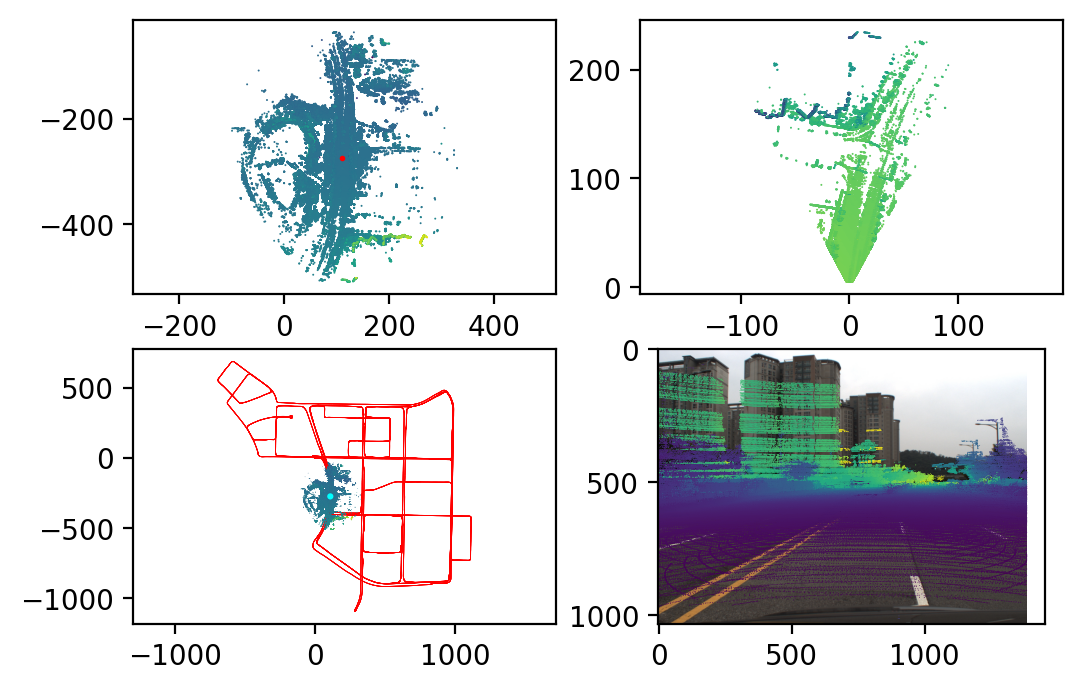

In [7]:
# merged LiDAR points around the vehicle
plt.subplot(2,2,1)
plt.scatter(merged_pnts[:,0], merged_pnts[:,1], s=0.5, c=merged_pnts[:,2], edgecolors='none')
plt.scatter(veh_pose[0,3], veh_pose[1,3], s=1, c='red')
plt.axis('equal')

# points visible from the camera
plt.subplot(2,2,2)
plt.scatter(cam_pnts[:,0], cam_pnts[:,2], s=0.5, c=cam_pnts[:,1], edgecolors='none')
plt.axis('equal')

# merged points on the map
plt.subplot(2,2,3)
plt.scatter(lcam_poses[:,0,3], lcam_poses[:,1,3], s=0.1, c='r', edgecolors='none')
plt.scatter(merged_pnts[:,0], merged_pnts[:,1], s=0.05, c=merged_pnts[:,2], edgecolors='none')
plt.scatter(lcam_poses[img_idx,0,3], lcam_poses[img_idx,1,3], s=5, c='cyan', edgecolors='none')
plt.axis('equal')

# projected LiDAR points
plt.subplot(2,2,4)
plt.imshow(img)
plt.scatter(uv[:,0], uv[:,1], s=0.1, c=cam_pnts[:,2], edgecolors='none')
plt.show()

In [ ]:
print